In [2]:
!pip install xgboost

  Using cached xgboost-3.1.1-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.1.1-py3-none-win_amd64.whl (72.0 MB)


📂 Loading race features...
Dataset shape: (200, 19)
Columns: ['season', 'round', 'race_name', 'circuit', 'driver', 'driver_id', 'team', 'team_id', 'grid_position', 'qualifying_time', 'final_position', 'points', 'dnf', 'recent_avg_position', 'avg_track_position', 'team_season_points', 'driver_dnf_rate', 'home_advantage', 'tire_strategy_score']

✅ All features found: ['grid_position', 'qualifying_time', 'recent_avg_position', 'avg_track_position', 'team_season_points', 'driver_dnf_rate', 'home_advantage', 'tire_strategy_score']

📊 Class Distribution:
   Total samples: 200
   Winners (1): 10 (5.00%)
   Non-winners (0): 190 (95.00%)

⚠️  Highly imbalanced dataset detected!
   Using scale_pos_weight for XGBoost

🔀 Data Split:
   Train set: 160 samples (8 winners)
   Test set: 40 samples (2 winners)

🚀 Training XGBoost model...


c:\Users\saksh\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:37:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Training complete!

📊 Model Performance:

Accuracy: 0.925
ROC-AUC Score: 0.947

📋 Classification Report:
              precision    recall  f1-score   support

  Non-Winner       0.95      0.97      0.96        38
      Winner       0.00      0.00      0.00         2

    accuracy                           0.93        40
   macro avg       0.47      0.49      0.48        40
weighted avg       0.90      0.93      0.91        40

🎯 Confusion Matrix:
[[37  1]
 [ 2  0]]
   True Negatives: 37
   False Positives: 1
   False Negatives: 2
   True Positives: 0

🔍 Feature Importance:
   grid_position            : 0.3328
   avg_track_position       : 0.2219
   recent_avg_position      : 0.1906
   qualifying_time          : 0.0959
   team_season_points       : 0.0853
   tire_strategy_score      : 0.0734
   driver_dnf_rate          : 0.0000
   home_advantage           : 0.0000

💾 Feature importance plot saved to ../ml_models/feature_importance.png
💾 Model saved to ../ml_models/xgboost_winner_mode

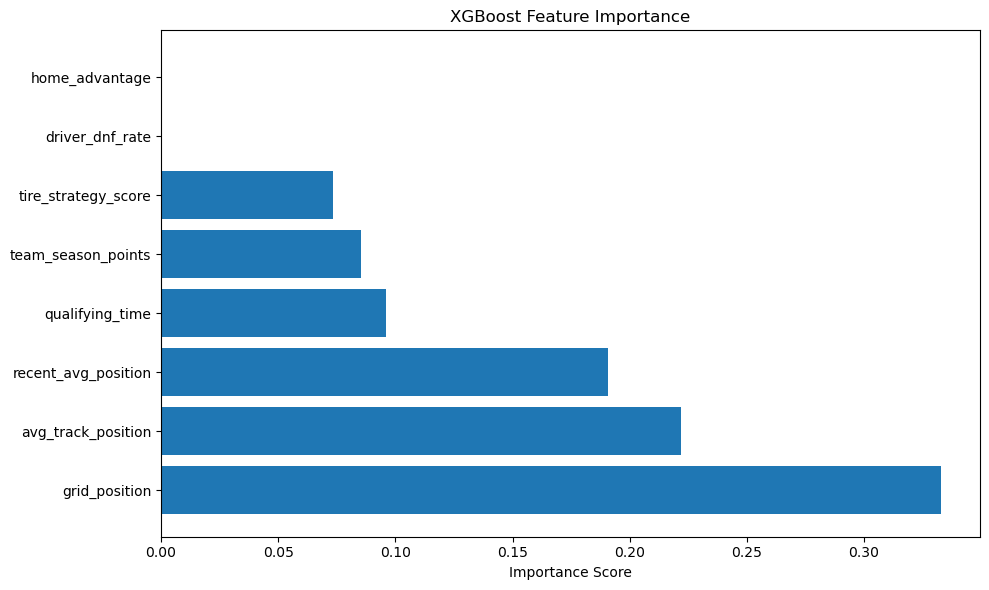

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, roc_auc_score, roc_curve)
import joblib
import os
import matplotlib.pyplot as plt

# Create ml_models directory if it doesn't exist
os.makedirs('../ml_models', exist_ok=True)

# ---------- LOAD DATA ----------
print("📂 Loading race features...")
df = pd.read_csv('../data/processed/race_features.csv')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}\n")

# ---------- FEATURE SELECTION ----------
features = [
    'grid_position',
    'qualifying_time',
    'recent_avg_position',
    'avg_track_position',
    'team_season_points',
    'driver_dnf_rate',
    'home_advantage',
    'tire_strategy_score'
]

# Verify all features exist
missing_features = [f for f in features if f not in df.columns]
if missing_features:
    print(f"⚠️  Missing features: {missing_features}")
    print(f"Available columns: {list(df.columns)}")
    raise ValueError("Required features missing from dataset")

print(f"✅ All features found: {features}\n")

# ---------- PREPARE DATA ----------
X = df[features].copy()
y = (df['final_position'] == 1).astype(int)  # Binary: winner vs not-winner

# Check class distribution
print(f"📊 Class Distribution:")
print(f"   Total samples: {len(X)}")
print(f"   Winners (1): {y.sum()} ({y.mean()*100:.2f}%)")
print(f"   Non-winners (0): {(~y.astype(bool)).sum()} ({(1-y.mean())*100:.2f}%)")

# Handle class imbalance
if y.mean() < 0.1:
    print(f"\n⚠️  Highly imbalanced dataset detected!")
    print(f"   Using scale_pos_weight for XGBoost")
    scale_pos_weight = (len(y) - y.sum()) / y.sum()
else:
    scale_pos_weight = 1

# ---------- TRAIN-TEST SPLIT ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n🔀 Data Split:")
print(f"   Train set: {len(X_train)} samples ({y_train.sum()} winners)")
print(f"   Test set: {len(X_test)} samples ({y_test.sum()} winners)")

# ---------- TRAIN MODEL ----------
print("\n🚀 Training XGBoost model...")

model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,  # Handle class imbalance
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

# Train with evaluation set
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(
    X_train, y_train,
    eval_set=eval_set,
    verbose=False
)

print("✅ Training complete!\n")

# ---------- EVALUATE MODEL ----------
print("📊 Model Performance:\n")

# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")

# ROC-AUC
try:
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC-AUC Score: {roc_auc:.3f}")
except:
    print("ROC-AUC: Not available (insufficient positive samples)")

# Classification Report
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Winner', 'Winner']))

# Confusion Matrix
print("🎯 Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(f"   True Negatives: {cm[0,0]}")
print(f"   False Positives: {cm[0,1]}")
print(f"   False Negatives: {cm[1,0]}")
print(f"   True Positives: {cm[1,1]}")

# ---------- FEATURE IMPORTANCE ----------
print("\n🔍 Feature Importance:")
importance_df = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

for idx, row in importance_df.iterrows():
    print(f"   {row['feature']:25s}: {row['importance']:.4f}")

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance Score')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.savefig('../ml_models/feature_importance.png', dpi=150)
print("\n💾 Feature importance plot saved to ../ml_models/feature_importance.png")

# ---------- SAVE MODEL ----------
model_path = '../ml_models/xgboost_winner_model.pkl'
joblib.dump(model, model_path)
print(f"💾 Model saved to {model_path}")

# Save feature list for inference
feature_list_path = '../ml_models/feature_list.txt'
with open(feature_list_path, 'w') as f:
    f.write('\n'.join(features))
print(f"💾 Feature list saved to {feature_list_path}")

# ---------- TEST PREDICTIONS ----------
print("\n🧪 Sample Predictions:\n")

# Test on first 5 samples
for i in range(min(5, len(X_test))):
    sample = X_test.iloc[i:i+1]
    actual = y_test.iloc[i]
    prob = model.predict_proba(sample)[0]
    
    print(f"Sample {i+1}:")
    print(f"   Grid Position: {sample['grid_position'].values[0]:.0f}")
    print(f"   Recent Avg Position: {sample['recent_avg_position'].values[0]:.2f}")
    print(f"   Team Points: {sample['team_season_points'].values[0]:.0f}")
    print(f"   Predicted Win Prob: {prob[1]:.3f}")
    print(f"   Actual Winner: {'Yes' if actual == 1 else 'No'}")
    print()

print("✅ Training pipeline complete!")